# L-Deep Neural Network Implementation

In this homework, you will develop, train, and test a generic fully connected L-Layer Neural Network. You will use your network as a binary classifier for faces and general images.

Many of the guardrails present in Homework #1 were removed. You will have more freedom on the implementation, but that will also increase the complexity of the homework. Make sure that you start early. Network training takes time and many trials.

**General Instructions**
1. All coding should be done in Python 3
2. Follow the instructions provided in each cell and complete each sub-task.
    1. Always vectorize your code when possible
    2. Create a Code and Markdown cells after each subtask to test and document your progress, respectively.
    3. Comment your code thoroughly
    4. For cells that explicitly require a "write-up," complete those portions on the provided Word template.
3. Export your notebook and Word file in PDF format. Make sure that your PDF contains all notebook output.
4. Submit the PDF files and your Jupyter Notebook.


**Homework parts:**
1. Load, pre-process, and split the dataset [Points: 20]
2. Build L-Layer Deep Neural Network Components [Points: 40]
3. Build a 2-Layer Neural Network [Points: 25]
4. Build an L-layer Neural Network [Points: 15]
5. Hyper-parameter exploration, results analysis, and self-test [Points: 20] [Optional for COSC424]

Recall that your will add custom code between the lines:\
/###############################\
/## YOUR CODE STARTS HERE\
\
/## YOUR CODE ENDS HERE\
/###############################\

In [ ]:
### v1.0

## 0 - Packages, setup, and helper functions

In [ ]:
import os 
import time
import copy
import h5py
import glob
import scipy
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy.random import Generator, PCG64DXSM
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from scipy import ndimage

# Using PCG64 as random generator
# Place seed [optional] for troubleshooting
rng = Generator(PCG64DXSM(seed=21))

# matplotlib general set up
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# This is helper function I use when fine-tuning large networks or when the gradient descent iterations are more than needed. 
# I use this after verifying proper data normalization and weight initialization. This removes activation output out of the
# domain of the cost and derivatives steps (e.g., log(0) and division by zero). You may not need this. If you use it, use it with caution.
def replace_out_domain(A):
    
    epsilon = np.finfo(np.float32).eps
    A[A==0] = epsilon
    A[A==1] = 1.0 - epsilon

    #return NaN safe A
    return A

## 1 - Load, pre-process, and split the Dataset [Points: 20]

You will be using a subset of the Caltech-101 dataset. For this binary classification problem, we will focus on the face and background sets.

The size of the images vary.

Instructions:
1. Download dataset from Canvas
2. Unzip and place data folder on your notebook root folder.
3. Identify the Faces and BACKGROUND_Google subfolders
4. Load the dataset to memory.
5. Pre-process the dataset.
6. Split the dataset in a 70/30 ratio: generate a training set with ~70% of the samples and a validation set with ~30% of the samples. 
    1. Note that we are not generating a test set for this homework.
    2. Identify the face_id.csv file, which gives a unique ID to each face in the dataset. How is this file important when generating the training and validation sets?

### 1.0 Load dataset [DO NOT CHANGE]


In [ ]:

# Load face and background images
def load_data(data_folder_path):

    # Array to save images and corresponding label    
    back_imgs = []
    face_imgs = []
    face_ids = []

    # Load CSV file with face ids
    column_name = ['FILENAME', 'FACEID'] 
    face_image_id_table = pd.read_csv(os.path.join(data_folder_path, "face_id.csv"), names=column_name, header=None)

    # Load images
    # Faces 
    for idx in face_image_id_table.index:
        path2img = os.path.join(data_folder_path, "Faces", face_image_id_table[column_name[0]][idx])
        im=Image.open(path2img)                     #load image
        face_imgs.append(ImageOps.grayscale(im))   #store grayscale image
        face_ids.append(face_image_id_table[column_name[1]][idx])

    # Background
    for filename in glob.glob(os.path.join(data_folder_path, 'BACKGROUND_Google', '*.jpg')):
        im=Image.open(filename)                     #load image
        back_imgs.append(ImageOps.grayscale(im))    #store grayscale image

    # Convert to face ids to numpy array
    face_ids = np.array(face_ids).reshape(len(face_ids), 1)
    
    # Return raw dataset
    return face_imgs, face_ids, back_imgs

### 1.0.0 Verify dataset is loading correctly

Add the path to the data folder below and run the cell.

In [ ]:

###############################
## YOUR CODE STARTS HERE
path_to_data_folder = "./data"
## YOUR CODE ENDS HERE
###############################


# Make sure that image
orig_face_imgs, face_ids, orig_back_imgs = load_data(path_to_data_folder)

# Example of face and background images
# Face and background index
face_index = 10
back_index = 30

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(orig_face_imgs[face_index])
plt.title("Face Example: ID: " + str(face_ids[face_index]) + ", Shape: " + str(orig_face_imgs[face_index].size))
plt.subplot(1, 2, 2)
plt.imshow(orig_back_imgs[back_index])
plt.title("Background Example: Shape: " + str(orig_back_imgs[back_index].size))

# Print out size of dataset
print("Dataset statistics:")
print("Number of face images is " + str(len(orig_face_imgs)))
print("Number of face IDs is " + str(face_ids.shape[0]))
print("Number of background images is " + str(len(orig_back_imgs)))



### 1.1 Process dataset

In this task you will pre-process the dataset for ingestion by the model. You will build three functions that will perform the following steps:
1. Make images of same size (50, 50)
2. Normalize by $I = \frac{I - \min(I)}{(\max(I)-\min(I))}$
3. Flatten images to vectors for ingestion into our networks

In [ ]:
def reshape_images(images, new_size):
    """
    Implements function that reshapes list of Pillow Images of size (n, p) to size (nn, pp).

    Arguments:
    images -- list of Pillow images of size (n,p)
    new_size -- tuple (nn, pp) with desired image size

    Returns:
    new_imgs -- list of reshaped images (nn, pp)
    """

    # list storing new images
    new_imgs = []

    ###############################
    ## YOUR CODE STARTS HERE
    

    ## YOUR CODE ENDS HERE
    ###############################
    
    #return new images of same shape
    return new_imgs



def flatten_norm_imgs(images):
    """
    Implements function that converts 2-D images to 1-D floating point vectors and normalize the image to values between 0 and 1. 
    This function should return a floating point numpy matrix of size (nx,m), where nx is the size of the images (i.e., nx =n*p) 
    and m is the number of images.

    Arguments:
    images -- list of Pillow images of size (n,p) and pixel values between 0 and 255

    Returns:
    new_imgs -- (nx, m) matrix of Numpy floating point flatten images, where each image is in a column of new_img. The 
    values of this matrix are between 0 and 1.
    """

    ###############################
    ## YOUR CODE STARTS HERE
    
    ## YOUR CODE ENDS HERE
    ###############################

    #return new images
    return new_imgs

### 1.1.1 Reshape, flatten, norm images
Use the functions build previously to reshape images to the same size and then, flatten and normalize the images to numpy vectors. This is for testing purposes. You will build a function below that will reuse all these functions

In [ ]:
# Test the functions above here.

I_AM_TESTING = False
if(I_AM_TESTING):

    ###############################
    ## YOUR CODE STARTS HERE


    ## YOUR CODE ENDS HERE
    ###############################

### 1.2 Process dataset for training and testing

For this task, you will process the original Pillow images into Numpy matrices that are ready for model training and testing. This includes:
1. Resize images
2. Flatten images
3. Normalize images
4. Split the dataset in a training and validation set.
    1. Split the dataset according to the best practices discussed in class. E.g., avoid data leakage.
5. Generate the correct labels (i.e., ground truth) for your images. 
6. Analyze the final data sets 

In [ ]:
def split_faces(face_images, face_ids, training_ratio):
    '''
    This function receives a matrix (nx, m) of facial images and a vector of length m of facial IDs. 
    The image in column k of face_images corresponds to the face ID in element k of face_ids. 
    It splits this joint dataset in a training and validation sets.

    Arguments:
    face_images -- matrix (nx, m) with the facial images.
    face_ids -- Unique identifiers for the subjects images in the columns of face_images. If element k 
    and k+1 in face_ids has the same ID, it means that the images in column k and k+1 in face_images 
    belong to the same subject.
    training_ratio -- the percentage of the m samples that will land in the training set. Note that
    the percentage of validation samples is 1-training_ratio. Also note that some best practices will 
    not allow a perfect training_ratio split. So, you just need to stay as close to this ratio.

    Returns:
    train_faces -- matrix of size (nx, mt) with the training facial images. training_ratio = ~mt/m
    val_faces -- matrix of size (nx, mv) with the validation facial images. 1-training_ratio = ~mv/m
    '''

    ###############################
    ## YOUR CODE STARTS HERE


    ## YOUR CODE ENDS HERE
    ###############################
    
    return train_faces, val_faces

def split_background(back_images, training_ratio):
    '''
    This function receives a matrix (nx, m) of background images.
    It splits this joint dataset in a training and validation sets.

    Arguments:
    back_images -- matrix (nx, m) with the background images.
    training_ratio -- the percentage of the m samples that will land in the training set. Note that
    the percentage of validation samples is 1-training_ratio. Also note that some best practices will 
    not allow a perfect training_ratio split. So, you just need to stay as close to this ratio.

    Returns:
    train_back -- matrix of size (nx, mt) with the training background images. training_ratio = ~mt/m
    val_back -- matrix of size (nx, mv) with the validation background images. 1-training_ratio = ~mv/m
    '''
    ###############################
    ## YOUR CODE STARTS HERE

    
    ## YOUR CODE ENDS HERE
    ###############################

    return train_backs, val_backs

def generate_final_train_val_sets(face_images, face_ids, back_images, training_ratio=0.70):
    '''
    This function receives two input matrices with data from each class. It splits the dataset in training and
    validation sets, then merges the classes and compute the corresponding ground truth labels.

    Arguments:
    face_images -- matrix (nx, m) with the facial images.
    face_ids -- Unique identifiers for the subjects images in the columns of face_images. If element k 
    and k+1 in face_ids has the same ID, it means that the images in column k and k+1 in face_images 
    belong to the same subject.
    back_images -- matrix (nx, m) with the background images.
    training_ratio -- the percentage of the m samples that will land in the training set. Note that
    the percentage of validation samples i 1-training_ratio. Also note that some best practices will 
    not allow a perfect training_ratio split. So, you just need to stay as close to this ratio.

    Returns:
    train_x -- it is a (nx, m) matrix with all training input samples as columns
    train_y -- it is a (1, m) row vector with the training ground truth labels
    val_x -- it is a (nx, mv) matrix with all validation input samples as columns
    val_y -- it is a (1, mv) row vector with the validation ground truth labels
    '''

    ###############################
    ## YOUR CODE STARTS HERE


    ## YOUR CODE ENDS HERE
    ###############################

    return train_x, train_y, val_x, val_y


### 1.3 Test split functions and get split
Use the cell below to test your split routines and obtain the train and validation sets with inputs and labels. You will build next a function that will integrate all pre-processing steps.

In [ ]:
# Assumes flat_face_imgs, and flat_back_imgs are available

if(I_AM_TESTING):

    # Generate X matrices and labels
    train_x_orig, train_y, val_x_orig, val_y = generate_final_train_val_sets(flat_face_imgs, face_ids, flat_back_imgs, 0.70)


    # Explore your dataset 
    m_train = train_x_orig.shape[1]
    m_val = val_x_orig.shape[1]
    training_split = (100.0*m_train)/ (m_val + m_train)

    print ("Number of training examples: " + str(m_train))
    print ("Number of testing examples: " + str(m_val))
    print ("train_x_orig shape: " + str(train_x_orig.shape))
    print ("train_y shape: " + str(train_y.shape))
    print ("val_x_orig shape: " + str(val_x_orig.shape))
    print ("val_y shape: " + str(val_y.shape))
    print("Training Split: " + str(round(training_split,1)) + "%")

### 1.4 Build data pre-processing function
This function will receive the original Pillow image arrays and return a training and testing ready dataset.

In [ ]:
def pre_process_dataset(orig_face_imgs, face_ids, orig_back_imgs, new_img_size):

    ###############################
    ## YOUR CODE STARTS HERE


    ## YOUR CODE ENDS HERE
    ###############################

    #return dataset
    return train_x_orig, train_y, val_x_orig, val_y

### 1.5 Pre-process your dataset

Write-up: Document how you split your dataset into the training and validation sets and provide a full justification for your approach.

**Write-up required**

In [ ]:

# Images new size
new_img_size = [50, 50]

# Pre-process data
train_x_orig, train_y, val_x_orig, val_y = pre_process_dataset(orig_face_imgs, face_ids, orig_back_imgs, new_img_size)

# 2. Build L-Layer Deep Neural Network Components [Points: 40]

In this section, you will build the functions needed to build an L-layer Neural Network. The components are:
1. Parameter initialization: Initialize parameters W and b for all layers the network
2. Activation functions and their derivatives
3. Forward and backward propagation functions
4. Cost function
5. Parameter updates following gradient descent rule. 

For this exercise, you will build all hidden layers with a ReLU activation function and a sigmoid activation function for the output layer.

### 2.1 Initialize model parameters
Build a function that initialize the model parameters $W^{[l]}$ and $b^{[l]}$ for an L-Deep Network.

Initialize your parameters $W^{[l]}$ and $b^{[l]}$ using the best practices discussed in class.

In [ ]:
def initialize_parameters_deep(layer_dims, init_style="small_normal", factor=0.01):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions $n^{[l]}$ of each layer in our L-layer network. 
    It should be L+1 long. 
    init-style -- either "small_normal" or "glorot" initialization schemes. For "small_normal" weights 
    are samples from a normal standard distribution and multiplied by factor. The "glorot" initialization scheme
    sample weights from a uniform distribution between -sqrt(6)/sqrt(n[l] + n[l-1]) and sqrt(6)/sqrt(n[l] + n[l-1]))
    factor -- float number between 0 and 1 used to scale samples from small_normal.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """

    #################################################
    # YOUR CODE STARTS HERE

        
    # YOUR CODE ENDS HERE
    ##################################################
        
    return parameters

### 2.2 Build Activation functions

Instructions build functions for the sigmoid, and ReLU functions and their corresponding derivatives.

In [ ]:
def sigmoid(Z):
    """
    Compute sigmoid of Z.

    Arguments:
    Z -- A numpy vector or matrix

    Return:
    s -- sigmoid(Z)
    """

    #########################
    # YOUR CODE STARTS HERE

    
    # YOUR CODE ENDS HERE
    #########################
    
    return s

def sigmoid_gradient(Z):
    """
    Compute derivative of sigmoid wrt to Z.

    Arguments:
    Z -- A numpy vector or matrix

    Return:
    s -- d sigmoid(Z) / dx
    """

    #########################
    # YOUR CODE STARTS HERE

    
    # YOUR CODE ENDS HERE
    #########################
    
    return ds


def relu(Z):
    """
    Compute relu of Z.

    Arguments:
    Z -- A numpy vector or matrix

    Return:
    r -- ReLU(Z)
    """

    #########################
    # YOUR CODE STARTS HERE

    
    # YOUR CODE ENDS HERE
    #########################
    
    return r

def relu_gradient(Z):
    """
    Compute derivative of relu wrt to Z.

    Arguments:
    Z -- A numpy vector or matrix

    Return:
    dr -- d relu(Z) / dZ
    """

    #########################
    # YOUR CODE STARTS HERE

    
    # YOUR CODE ENDS HERE
    #########################
    
    return dr

### 2.3 L-Layer Forward propagation functions

Instructions:
1. Build the function that computes $Z^{[l]}$
2. Then compute the activation step. Note that $A^{[l]}$ for $l<L$ uses a ReLU activation function and only the last layer L uses the Sigmoid activation function. Also store the computations required for the backpropagation step in the cache variable.
3. Integrate these functions to compute the forward propagation of the inputs through a generic L-layer network. 

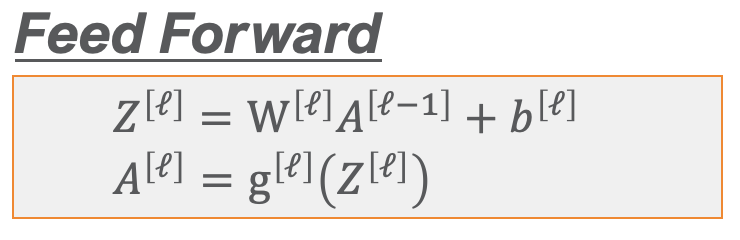

In [ ]:
def linear_forward(A, W, b):
    """
    Implement the affine transformation of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    ##########################
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    ##########################

    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for a layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently. "Linear_cache" is the cache 
             variables from linear_forward() and activation cache is Z.
    """
    
        
    ####################################
    # YOUR CODE STARTS HERE


    # YOUR CODE ENDS HERE
    ####################################

    return A, cache


def L_model_forward(X, parameters):
    """
    Implement forward propagation for RELU layers (i.e., 1 to L-1) and output SIGMOID layer (L)
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    #####################################################
    # YOUR CODE STARTS HERE

    
    # YOUR CODE ENDS HERE
    #####################################################
          
    return AL, caches

### 2.4 Cost

Compute the LogLoss Cost for predictions A and ground truth Y.

In [ ]:
def compute_cost(A, Y):
    """
    Computes the LogLoss/Cross-Entropy cost.
    
    Arguments:
    A -- The sigmoid output of the output layer with shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost as discussed in class
    """
    
    ####################################
    # YOUR CODE STARTS HERE


    # YOUR CODE ENDS HERE
    ####################################
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    
    return cost

### 2.5 L-Layer Back propagation functions

Instructions:
1. Compute the linear components of the backpropagation at layer l ($dW^{[l]}$, $db^{[l]}$, and $dA^{[l-1]}$)
2. Compute activation propagation $dZ^{[l]}$
3. Integrate these functions to fully compute the backpropagation from output layer to weight and parameters in the first layer.

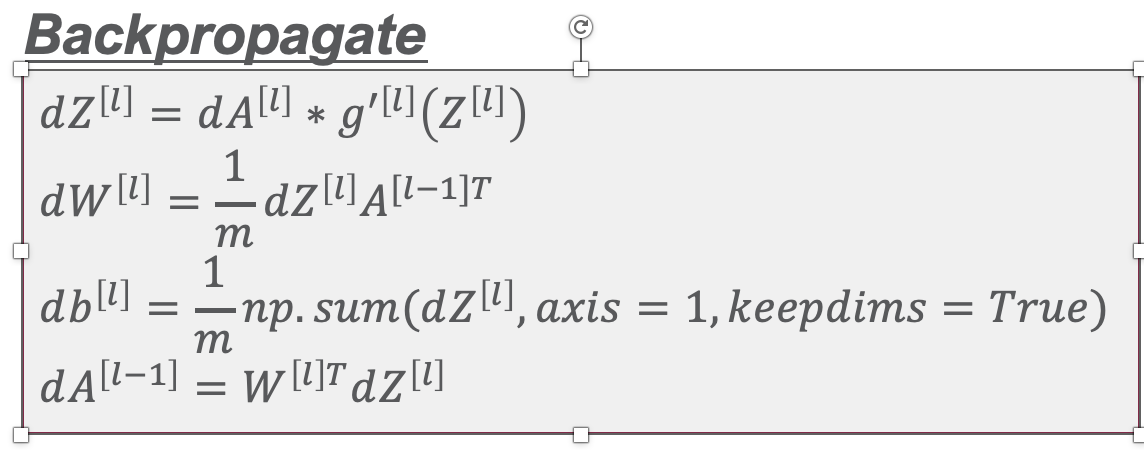

In [ ]:

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    ##################################
    ### START CODE HERE

    
    # YOUR CODE ENDS HERE
    ######################################
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the activation.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we stored for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """


    ##################################
    ### START CODE HERE
        
    # YOUR CODE ENDS HERE
    #######################################
        
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for output layer with a sigmoid activation function and hidden layers with a RELU activation function.
    
    Arguments:
    AL -- forward propagation activation output for layer L. It is a vector shape (1,m) (L_model_forward())
    Y -- true "label" vector (containing 0 if background, 1 if face) shape (1,m)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """


    ###############################################
    # YOUR CODE STARTS HERE

    
    # YOUR CODE ENDS HERE
    ################################################
        
    return grads


### 2.6 Update Parameters

Instructions:
1. Retrieve parameters from parameters dictionary
2. Retrieve gradients from grads dictionary
3. Update and store updated parameters

In [ ]:
# GRADED FUNCTION: update_parameters

def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    parameters = copy.deepcopy(params)

    #########################################
    # YOUR CODE STARTS HERE
        
    
    # YOUR CODE ENDS HERE
    ########################################
    return parameters

### 2.7 Predict with N-Layer Model

Build the predict function with inputs X and model parameters. Assumes sigmoid activation function in the output.

In [ ]:
def predict(parameters, X, Y):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    Y -- True labels to compute cost
    
    Returns
    predictions -- vector of predictions of our model
    cost -- cost of predictions
    """
    
    ###############################
    # YOUR CODE STARTS HERE


    # YOUR CODE ENDS HERE
    ################################
    
    return predictions, cost

### 2.8 Compute Accuracy of model
Build function that returns the accuracy of the model as a percentage. 

$accuracy = 100*\frac{TP + TN}{TP+FP+TN+FN}$

In [ ]:
def accuracy_compute(Yhat, Y):
    """
    Computes the accuracy of the predictions given a prediction vector Yhat and a ground truth vector Y.

    Arguments:
    Yhat -- prediction vector with shape (1,m)
    Y -- ground truth vector with shape (1,m)

    Returns:
    accuracy -- percentage of Correct Predictions / Total samples.
    """


    ###############################
    # YOUR CODE STARTS HERE


    # YOUR CODE ENDS HERE
    ################################

    return accuracy

## 3. Build a 2-Layer Neural Network [Points: 25]

Use the functions you implemented previously to build an $2$-layer neural network with the following structure: Inputs -> ReLU Layers -> Sigmoid Output Layer.

The functions, input arguments, and output arguments are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 

def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache

def compute_cost(AL, Y):
    ...
    return cost

def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
    
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

### 3.1 Build two_layer_model function.

In [ ]:
def two_layer_model(X, Y, layers_dims, init_scheme, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if face, 0 if non-face), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    init_scheme -- Tuple with ("small_normal", factor) or ("glorot", factor). See initialize_parameters_deep
    function for more details. Note that when using "glorot", factor float number is ignored.
    num_iterations -- number of iterations of the gradient descent optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, b1, W2, and b2
    """

    #################################################################
    #YOUR CODE STARTS HERE

   

    #YOUR CODE ENDS HERE
    #################################################
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

### 3.2 Train, test, and assess 2-Layer network model performance

Instructions:
1. Build a network with $n^{[1]}=5$ hidden units
2. Plot the cost per iteration for training set. Use num_iterations=1000
3. Compute the accuracy of the system on the training and test set.
4. Repeat steps 1 and 2 for $n^{[1]} \in {50, 200, 500, 1000}$ 
    4.2 Runs for 500 or more hidden units can take several minutes to complete.
5. Plot the cost for the training and test sets as a function of capacity (i.e., $n^{[1]}$)
6. Document your observations ("Write-up")
    1. Look for overfitting, high/low bias, high/low variance, optimal hidden unit size, slow vs fast convergence, etc.
    2. Provide the cost vs iterations for each $n_h$ and the cost vs capacity plots
    3. Fine-tune and select hyperparameters. Document the why behind your selection.

**Expectation**
1. Your training set accuracy should be above 90%

**Write-up required**

In [ ]:

# Recall data variables: train_x_orig, train_y, val_x_orig, val_y 

####################################################
# YOUR CODE STARTS HERE

# YOUR CODE ENDS HERE
#####################################################


## 4 - L-layer Neural Network [Points: 15]

Use the functions you implemented previously to build an $L$-layer neural network with the following structure: Inputs -> ReLU Layers * (L-1) -> Sigmoid Output Layer.


The functions, input arguments, and outputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

**Make sure your 2-Layer Network works, before continuing with this exercise.**

### 4.1 Build N-Layer Network function [Points: ]

In [ ]:
def L_layer_model(X, Y, layers_dims, init_scheme, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network.

    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if face, 0 if background), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    init_scheme -- Tuple with ("small_normal", factor) or ("glorot", factor). See initialize_parameters_deep
    function for more details. Note that when using "glorot", factor is ignored.
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    #######################################################
    # YOUR CODE STARTS HERE

    
    # YOUR CODE ENDS HERE
    ###############################################################################        
     

    return parameters, costs

### 4.2 - Train the model

Build a 4-layer network with hidden layers 1, 2, and 3 with 51, 25, and 15 units respectively. 

- The cost should decrease on every iteration. 
- It may take up to 5 minutes to run 5000 iterations. 


**Write-up required**

In [ ]:
# Recall data variables: train_x_orig, train_y, val_x_orig, val_y 

####################################################
# YOUR CODE STARTS HERE

# YOUR CODE ENDS HERE
####################################################



---

# Remaining sections of homework are mandatory for COSC 525 students and bonus for COSC 424 students

---

## 5.0 Hyper-parameter exploration, results analysis, and self-test [Points: 20]

### 5.1 Explore your hyperparameters. 

- Build at least three different networks that vary in depth and number of hidden units.
- Also, explore the impact of learning rate and initialization scheme on model performance.
- Document your observations 
    1. Compare capacity of networks 
    2. Provide cost vs iteration and cost vs capacity plots
    3. Select best parameters and thoroughly explain your decision.

**Write-up required**

In [ ]:
# Recall data variables: train_x_orig, train_y, val_x_orig, val_y 

####################################################
# YOUR CODE STARTS HERE

# YOUR CODE ENDS HERE
####################################################

###  5.2 - Results Analysis

Visualize some of the model mistakes and document your intuition for these errors.

**Write-up required.**

In [ ]:
####################################################
# YOUR CODE STARTS HERE

# YOUR CODE ENDS HERE
####################################################

### 5.3 - Test with your own image

- Test your model with at least 2 facial and 2 background images.
- Document your experience.

**Write-up required.**

In [ ]:
####################################################
# YOUR CODE STARTS HERE

# YOUR CODE ENDS HERE
####################################################

# Congratulations! You have completed homework #2. This was a challenging homework, but it gave you a framework to build any type of network. It was worth the effort. Now you can say: "I built a deep neural network from scratch."